In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [3]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_one_store_backlogged"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

architectures = {
    "Vanilla NN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_store',
    "base_stock": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/base_stock_distribution',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

config = "one_store_backlogged"
store_lead_times = [1, 4, 7, 10, 15, 20]
store_underage_costs = [4, 9, 19, 39]

dfs = []

for arch_name, path_fn in architectures.items():
    path = path_fn(config)

    df = results_interpretor.make_table({1: path},
        {'store_underage_cost': store_underage_costs,
            'store_lead_time': store_lead_times},
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
    if df.empty:
        continue

    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    df['config'] = config
    dfs.append(df)

if not dfs:
    raise ValueError("No dataframes found for the given settings.")

df = pd.concat(dfs, ignore_index=True)

In [4]:
import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'one_store_backlogged_test_loss.txt'

vanilla_mask = df['Architecture Class'] == 'Vanilla NN'
test_losses = []
for _, row in df[vanilla_mask].iterrows():
    test_loss_path = str(row['path']) + "/" + test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df.loc[vanilla_mask, test_loss_column] = test_losses

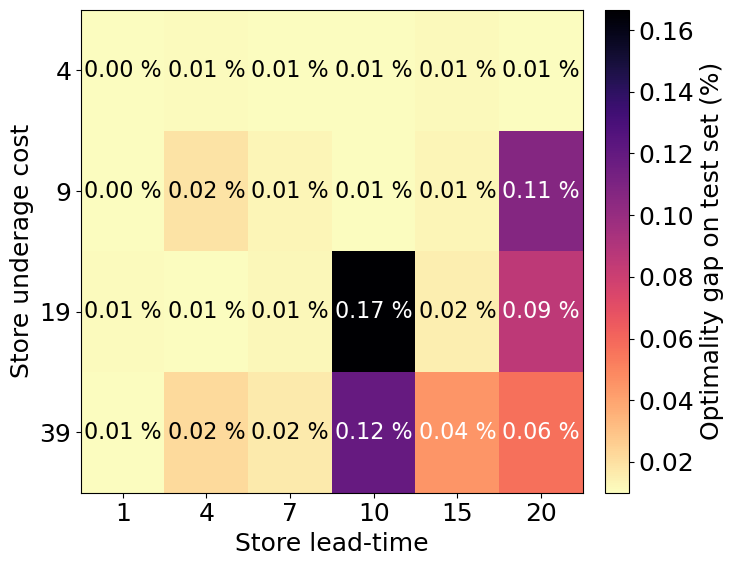

In [ ]:
# Find optimal losses for each (store_lead_time, store_underage_cost) using base_stock (optimal policy)
optimal_losses = {}
for store_lead_time in store_lead_times:
    for store_underage_cost in store_underage_costs:
        optimal_data = df[
            (df['Architecture Class'] == 'base_stock') &
            (df['store_lead_time'] == store_lead_time) &
            (df['store_underage_cost'] == store_underage_cost)
        ]
        if not optimal_data.empty:
            optimal_losses[(store_lead_time, store_underage_cost)] = optimal_data['Test Loss'].min()

# Build heatmap data for Vanilla NN
heatmap_data = np.full((len(store_underage_costs), len(store_lead_times)), np.nan)
for i, store_underage_cost in enumerate(store_underage_costs):
    for j, store_lead_time in enumerate(store_lead_times):
        optimal_loss = optimal_losses.get((store_lead_time, store_underage_cost), None)
        if optimal_loss is None:
            continue
        system_data = df[
            (df['store_lead_time'] == store_lead_time) &
            (df['store_underage_cost'] == store_underage_cost) &
            (df['Architecture Class'] == 'Vanilla NN')
        ]
        if not system_data.empty:
            test_losses = system_data['Test Loss'].to_numpy()
            mean_test_loss = np.mean(test_losses)
            gap = ((mean_test_loss - optimal_loss) / optimal_loss) * 100
            heatmap_data[i, j] = gap

FONTSIZE = 18
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': FONTSIZE})

cmap = plt.get_cmap("magma_r")
vmin = 0.01
vmax = np.nanmax(heatmap_data)
im = plt.imshow(heatmap_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='upper')

for i in range(len(store_underage_costs)):
    for j in range(len(store_lead_times)):
        val = heatmap_data[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.2f} %", ha="center", va="center", color="white" if val > 0.035 else "black", fontsize=FONTSIZE-2)

plt.xlabel('Store lead-time', fontsize=FONTSIZE)
plt.ylabel('Store underage cost', fontsize=FONTSIZE)
plt.xticks(np.arange(len(store_lead_times)), store_lead_times, fontsize=FONTSIZE)
plt.yticks(np.arange(len(store_underage_costs)), store_underage_costs, fontsize=FONTSIZE)

ax = plt.gca()
pos = ax.get_position()
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_position([pos.x1 + 0.01, pos.y0, 0.03, pos.height])
cbar.set_label('Optimality gap on test set (%)', fontsize=FONTSIZE)

plt.tight_layout()
plt.savefig("/user/ml4723/Prj/NIC/Plots/backlogged_test_gap.pdf", bbox_inches='tight')
plt.show()

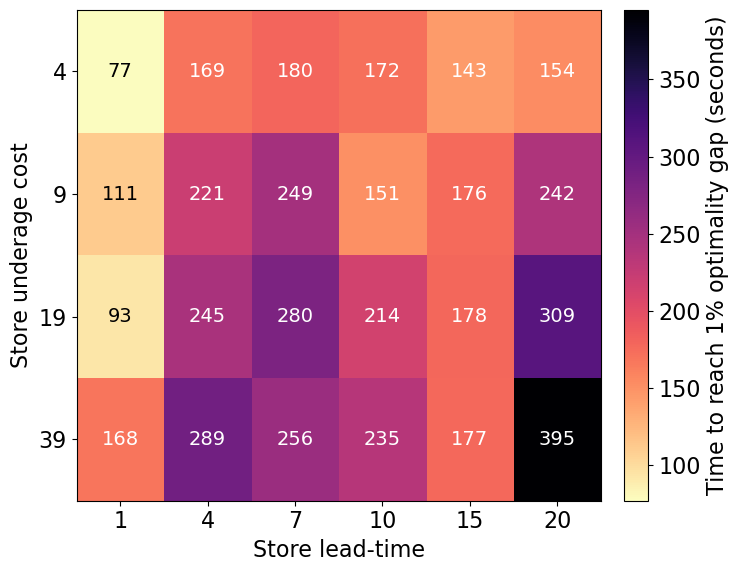

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lead_time_col = "store_lead_time"
underage_cost_col = "store_underage_cost"
hyperparam_col = "hyperparam_name"
base_stock_hyperparam = "base_stock"

store_lead_times = sorted(df[lead_time_col].unique())
store_underage_costs = sorted(df[underage_cost_col].unique())

base_stock_mask = df[hyperparam_col] == base_stock_hyperparam
base_stock_df = df[base_stock_mask]
base_stock_losses = {}
for _, row in base_stock_df.iterrows():
    key = (row[lead_time_col], row[underage_cost_col])
    base_stock_losses[key] = row["Dev Loss"]

vanilla_df = df[df[hyperparam_col] != base_stock_hyperparam].copy()

heatmap_data = np.full((len(store_underage_costs), len(store_lead_times)), np.nan)

for _, row in vanilla_df.iterrows():
    key = (row[lead_time_col], row[underage_cost_col])
    if key not in base_stock_losses:
        continue
    import os
    progress_path = os.path.join(row["path"], "progress.csv")
    try:
        progress_df = pd.read_csv(progress_path)
        base_dev_loss = base_stock_losses[key]
        dev_gap_threshold = 0.01 * base_dev_loss
        first_time = progress_df["time_total_s"].iloc[0]
        found = False
        for idx, prog_row in progress_df.iterrows():
            dev_gap = abs(prog_row["dev_loss"] - base_dev_loss)
            if dev_gap <= dev_gap_threshold:
                time_to_1pct = prog_row["time_total_s"] - first_time
                found = True
                break
        if not found:
            time_to_1pct = np.nan
    except Exception:
        time_to_1pct = np.nan

    i = store_underage_costs.index(row[underage_cost_col])
    j = store_lead_times.index(row[lead_time_col])
    if not pd.isna(time_to_1pct):
        heatmap_data[i, j] = int(time_to_1pct)

FONTSIZE = 16
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': FONTSIZE})

cmap_name = "magma_r"
cmap = plt.get_cmap(cmap_name)

valid_vals = heatmap_data[~np.isnan(heatmap_data)]
vmin = np.nanmin(heatmap_data)
vmax = np.nanmax(heatmap_data)

im = plt.imshow(heatmap_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', origin='upper')

for i in range(len(store_underage_costs)):
    for j in range(len(store_lead_times)):
        val = heatmap_data[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val > 130 else "black", fontsize=FONTSIZE-2)

plt.xlabel('Store lead-time', fontsize=FONTSIZE)
plt.ylabel('Store underage cost', fontsize=FONTSIZE)
plt.xticks(np.arange(len(store_lead_times)), store_lead_times, fontsize=FONTSIZE)
plt.yticks(np.arange(len(store_underage_costs)), store_underage_costs, fontsize=FONTSIZE)

# Set the colorbar to match the heatmap's vertical position and height
ax = plt.gca()
pos = ax.get_position()
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.set_position([pos.x1 + 0.01, pos.y0, 0.03, pos.height])
cbar.set_label('Time to reach 1% optimality gap (seconds)', fontsize=FONTSIZE)

plt.tight_layout()

plt.savefig("/user/ml4723/Prj/NIC/Plots/backlogged_time_outperform_dev_approx.pdf", bbox_inches='tight')

plt.show()

In [11]:
import numpy as np
import pandas as pd

lead_time_col = "store_lead_time"
underage_cost_col = "store_underage_cost"
train_loss_col = "Train Loss"
dev_loss_col = "Dev Loss"
test_loss_col = "Test Loss"
hyperparam_col = "hyperparam_name"
base_stock_hyperparam = "base_stock"

# Get base stock policy losses for each (lead_time, underage_cost)
base_stock_mask = df[hyperparam_col] == base_stock_hyperparam
base_stock_df = df[base_stock_mask]
base_stock_losses = {}
for _, row in base_stock_df.iterrows():
    key = (row[lead_time_col], row[underage_cost_col])
    base_stock_losses[key] = {
        "train": row[train_loss_col],
        "dev": row[dev_loss_col],
        "test": row[test_loss_col]
    }

# Exclude base_stock rows from the table
vanilla_df = df[df[hyperparam_col] != base_stock_hyperparam].copy()

table_rows = []
for _, row in vanilla_df.iterrows():
    key = (row[lead_time_col], row[underage_cost_col])
    if key not in base_stock_losses:
        continue
    base = base_stock_losses[key]
    train_gap = 100 * (row[train_loss_col] - base["train"]) / base["train"]
    dev_gap = 100 * (row[dev_loss_col] - base["dev"]) / base["dev"]
    test_gap = 100 * (row[test_loss_col] - base["test"]) / base["test"]
    import os

    progress_path = os.path.join(row["path"], "progress.csv")
    try:
        progress_df = pd.read_csv(progress_path)
        base_dev_loss = base["dev"]
        dev_gap_threshold = 0.01 * base_dev_loss
        first_time = progress_df["time_total_s"].iloc[0]
        found = False
        for idx, prog_row in progress_df.iterrows():
            dev_gap = abs(prog_row["dev_loss"] - base_dev_loss)
            if dev_gap <= dev_gap_threshold:
                time_to_1pct = prog_row["time_total_s"] - first_time
                found = True
                break
        if not found:
            time_to_1pct = np.nan
    except Exception as e:
        time_to_1pct = np.nan
    table_rows.append([
        int(row[lead_time_col]),
        int(row[underage_cost_col]),
        round(row[train_loss_col], 2),
        round(row[dev_loss_col], 2),
        round(row[test_loss_col], 2),
        f"{train_gap:.2f}",
        f"{dev_gap:.2f}",
        f"{test_gap:.2f}",
        int(time_to_1pct) if not pd.isna(time_to_1pct) else ""
    ])

table_df = pd.DataFrame(table_rows, columns=[
    "Store lead-time",
    "Store under-age cost",
    "Train loss",
    "Dev loss",
    "Test loss",
    "Train gap (%)",
    "Dev gap (%)",
    "Test gap (%)",
    "Time to 1% dev gap (s)"
])

table_df = table_df.sort_values(["Store lead-time", "Store under-age cost"]).reset_index(drop=True)
table_df

,Store lead-time,Store under-age cost,Train loss,Dev loss,Test loss,Train gap (%),Dev gap (%),Test gap (%),Time to 1% dev gap (s)
0,1,4,3.17,3.17,3.17,0.01,0.02,0.00,77
1,1,9,3.97,3.97,3.97,0.01,0.03,0.00,111
2,1,19,4.68,4.67,4.67,0.02,0.04,0.01,93
3,1,39,5.29,5.29,5.29,0.01,0.05,0.01,168
4,4,4,5.01,5.01,5.01,0.01,0.05,0.01,169
5,4,9,6.30,6.27,6.28,0.02,0.06,0.02,221
6,4,19,7.37,7.39,7.38,0.03,0.07,0.01,245
7,4,39,8.36,8.37,8.37,0.00,0.08,0.02,289
8,7,4,6.33,6.34,6.33,0.01,0.06,0.01,180
9,7,9,7.94,7.92,7.94,0.06,0.08,0.01,249


In [7]:
mode = "test"
setting_names = ['one_store_backlogged']

models = []
for _, row in df.iterrows():
    models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 2, 3]

import nest_asyncio
import asyncio

nest_asyncio.apply()

async def run_main_run(model_path, setting_name, gpu_idx, semaphore):
    async with semaphore:
        try:
            hyperparam_name = model_path.split('/')[7]
            print(f"Running main_run.py for path {model_path}")
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                mode,
                setting_name,
                hyperparam_name,
                str(model_path),
                str(gpus[gpu_idx])
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            process = await asyncio.create_subprocess_exec(
                *cmd,
                env=env,
                cwd="/user/ml4723/Prj/NIC/",
                stdout=asyncio.subprocess.PIPE,
                stderr=asyncio.subprocess.PIPE
            )
            stdout, stderr = await process.communicate()
            if process.returncode != 0:
                print(f"Error running main_run.py for path {model_path}: {stderr.decode()}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {model_path}: {e}")

async def main():
    max_concurrent = 12 * len(gpus)
    semaphore = asyncio.Semaphore(max_concurrent)
    tasks = []
    gpu_idx = 0
    for setting_name in setting_names:
        for path in models:
            tasks.append(run_main_run(path, setting_name, gpu_idx, semaphore))
            gpu_idx = (gpu_idx + 1) % len(gpus)
    await asyncio.gather(*tasks)

await main()


Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_store_backlogged/vanilla_one_store/run_2025-05-22_12-06-47/run_c354a_00000_0_config=one_store_backlogged,early_stop_check_epochs=10,learning_rate=0.0010,repeats=1,stop_if_no_improve_for_epo_2025-05-22_12-06-47/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_store_backlogged/vanilla_one_store/run_2025-05-22_08-17-34/run_be121_00001_1_config=one_store_backlogged,early_stop_check_epochs=10,learning_rate=0.0010,repeats=1,stop_if_no_improve_for_epo_2025-05-22_08-17-35/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_store_backlogged/vanilla_one_store/run_2025-05-22_08-17-34/run_be121_00002_2_config=one_store_backlogged,early_stop_check_epochs=10,learning_rate=0.0010,repeats=1,stop_if_no_improve_for_epo_2025-05-22_08-17-35/model.pt
Running main_run.py for path /U